# Regional Relevance Analysis using MediaPipe

### Overview
This notebook demonstrates how to quantify and compare LRP (Layer-wise Relevance Propagation) scores across specific facial regions. 
By mapping MediaPipe landmarks to semantic areas (like eyes, mouth, nose), we can analyze whether human observers and the model focus on the same features when judging facial similarity.

## 1. Extracting Landmarks with MediaPipe

MediaPipe's Face Mesh is a high-fidelity face tracking solution that estimates 468 3D face landmarks in real-time. 
We use it here to establish a consistent coordinate system across different face images, allowing us to define stable facial regions regardless of slight pose variations.

### 1.1 Initialize MediaPipe and Load Sample

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from facesim3d import local_paths


# Initialize mediapipe face mesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# Load image
image_folder = local_paths.DIR_FRONTAL_VIEW_HEADS
image_path = os.path.join(image_folder, "head-001_frontal.png")
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.resize(image, (224, 224))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
if not results.multi_face_landmarks:
    raise ValueError("No face detected.")

h, w = gray.shape
landmarks = results.multi_face_landmarks[0].landmark
points = np.array([[int(lm.x * w), int(lm.y * h)] for lm in landmarks])

I0000 00:00:1763721971.648681 3301516 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763721971.728625 3301608 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 580.82.07), renderer: NVIDIA A30/PCIe/SSE2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1763721971.736931 3301559 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763721971.753204 3301572 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763721971.758122 3301565 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


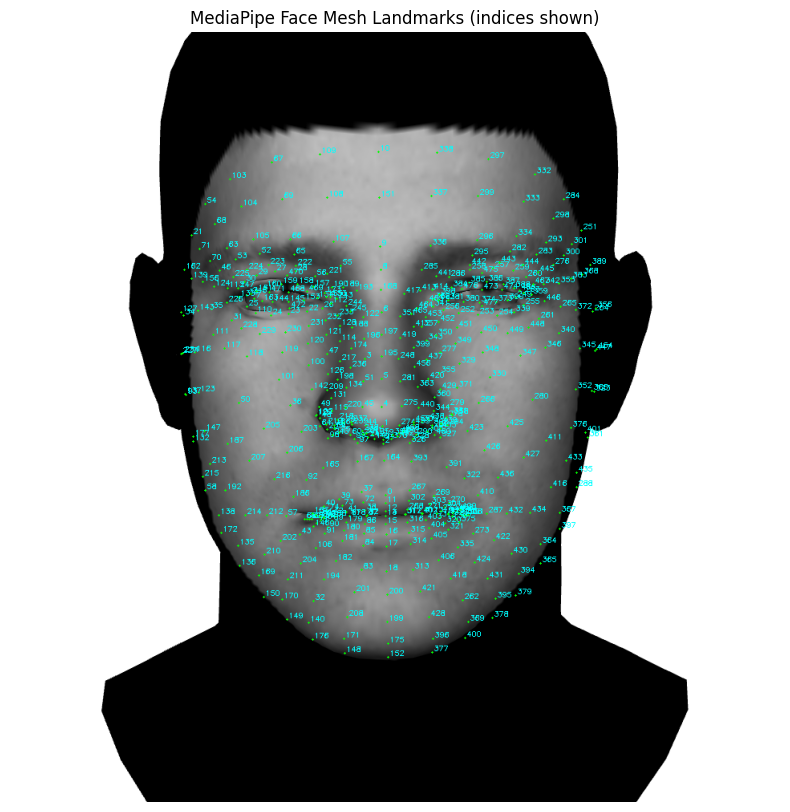

In [3]:
# --- Draw all landmarks with index numbers ---
vis = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

for i, (x, y) in enumerate(points):
    cv2.circle(vis, (x, y), 1, (0, 255, 0), -1)
    cv2.putText(vis, str(i), (x + 2, y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 255, 0), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("MediaPipe Face Mesh Landmarks (indices shown)")
plt.show()

In [ ]:
import csv
from collections import defaultdict

results_folder = local_paths.DIR_REGION_ANALYSIS_RESULTS
csv_path = os.path.join(results_folder, "landmark_annotations.csv")

# Build region → list of indices
region_map = defaultdict(list)
with open(csv_path, newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        idx = int(row["landmark_index"])
        region = row["region"].strip()
        region_map[region].append(idx)

In [ ]:
colors = {
    # Core facial features
    "mouth": (255, 102, 102),          
    "upper_lip": (255, 128, 128),
    "lower_lip": (255, 80, 80),
    "nose_tip": (255, 153, 51),        
    "nose_bridge": (255, 204, 102),
    
    # Eyes and brows
    "left_eye": (51, 204, 255),        
    "right_eye": (0, 153, 204),
    "left_eyebrow": (102, 255, 178),   
    "right_eyebrow": (0, 204, 153),
    
    # Outline and extended regions
    "chin": (204, 153, 255),           
    "forehead": (255, 255, 102),       
    "left_cheek": (255, 178, 102),     
    "right_cheek": (255, 229, 153),
    "left_ear": (102, 178, 255),       
    "right_ear": (102, 102, 255),      
}

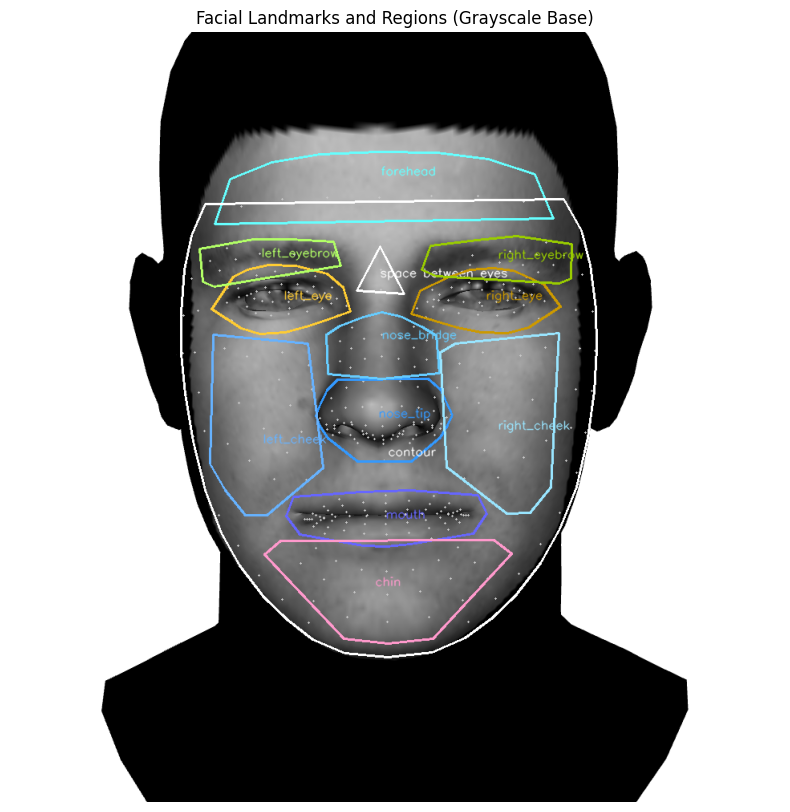

In [6]:
import matplotlib.pyplot as plt

# --- Copy grayscale image for drawing ---
vis = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)  # convert 1-channel → 3-channel for colored drawing

# Draw all landmarks as small gray dots
for (x, y) in points:
    cv2.circle(vis, (x, y), 1, (200, 200, 200), -1)

# Draw regions
for name, idxs in region_map.items():
    pts = points[idxs]
    hull = cv2.convexHull(pts)
    color = colors.get(name, (255, 255, 255))
    cv2.polylines(vis, [hull], isClosed=True, color=color, thickness=2)
    cv2.putText(vis, name, tuple(np.mean(hull.squeeze(), axis=0).astype(int)),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

# --- Show image with Matplotlib ---
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))  # convert BGR→RGB for matplotlib
plt.axis("off")
plt.title("Facial Landmarks and Regions (Grayscale Base)")
plt.show()

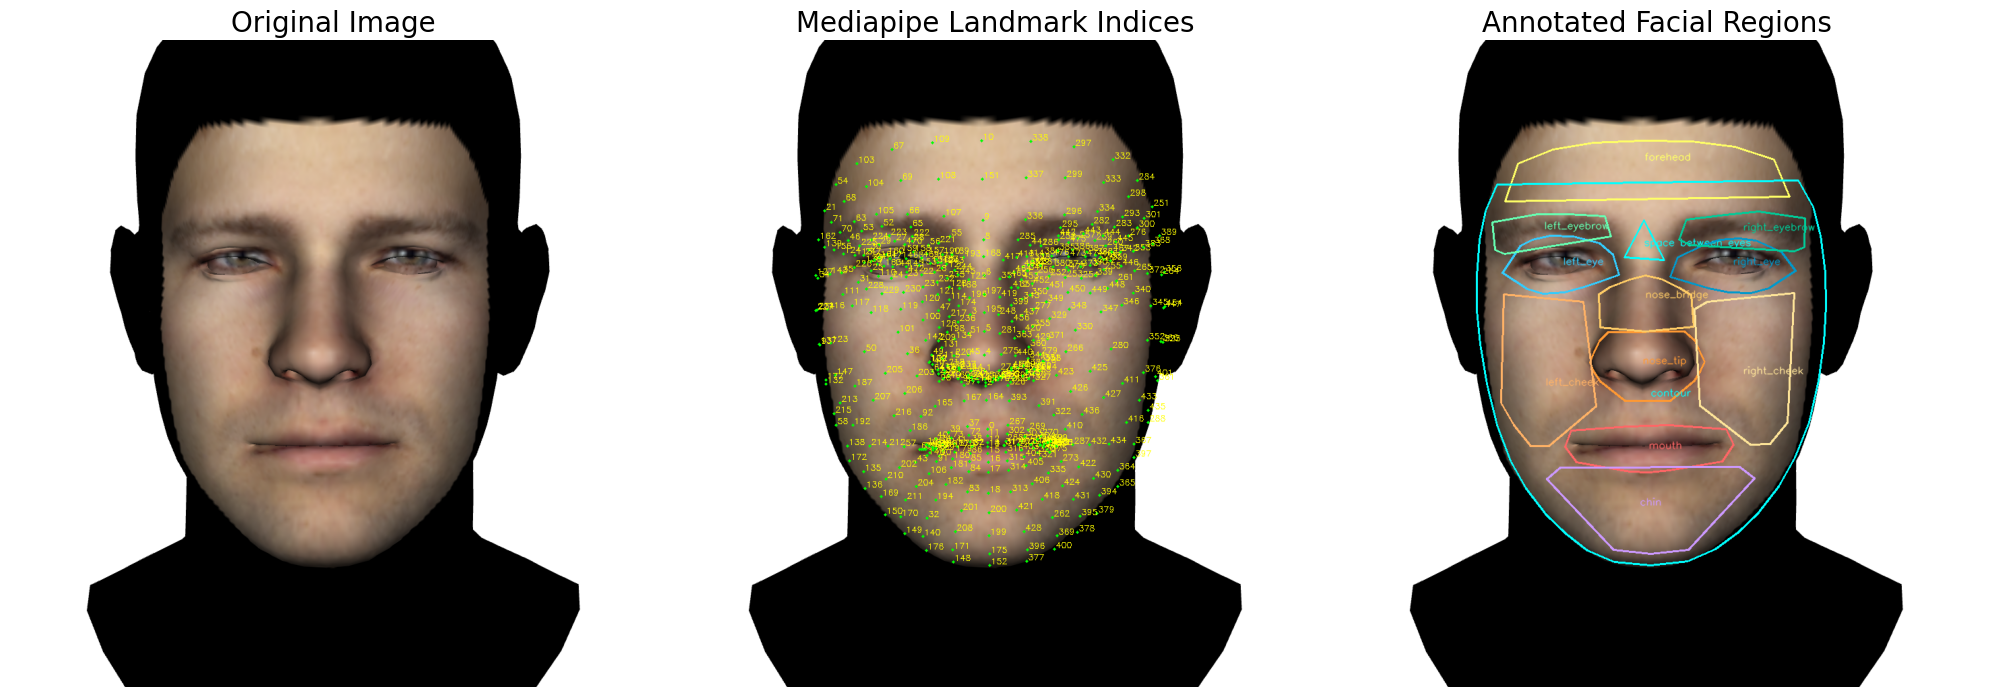

Saved figure: landmarks_3panel_plot.png


In [ ]:
# Build image with landmark indices  (color)
vis_idx = image.copy()

for i, (x, y) in enumerate(points):
    cv2.circle(vis_idx, (x, y), 2, (0, 255, 0), -1)              # green dot
    cv2.putText(vis_idx, str(i), (x+2, y-2),
                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 1)

# Build image with region polygons  (color)
vis_regions = image.copy()

for name, idxs in region_map.items():
    pts = points[idxs]
    hull = cv2.convexHull(pts)

    color = colors.get(name, (0, 255, 255))     # fallback: yellow
    cv2.polylines(vis_regions, [hull], isClosed=True, color=color, thickness=2)
    center = tuple(np.mean(hull.squeeze(), axis=0).astype(int))
    cv2.putText(vis_regions, name, center,
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)

# Create 1 figure with 3 subplots 
fig, axes = plt.subplots(1, 3, figsize=(20, 11))

axes[0].imshow(image)
axes[0].set_title("Original Image", fontsize=20)
axes[0].axis("off")

axes[1].imshow(vis_idx)
axes[1].set_title("Mediapipe Landmark Indices", fontsize=20)
axes[1].axis("off")

axes[2].imshow(vis_regions)
axes[2].set_title("Annotated Facial Regions", fontsize=20)
axes[2].axis("off")

plt.tight_layout()

# Save figure
#plt.savefig("img_langmarks_regions_plot.png", dpi=500)
plt.show()

## 2. Compute Relevance Values

In [7]:
# Load image again in smaller size to be somparable to the heatmaps of size 224,224
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (224, 224))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
if not results.multi_face_landmarks:
    raise ValueError("No face detected.")

h, w = gray.shape
landmarks = results.multi_face_landmarks[0].landmark
points = np.array([[int(lm.x * w), int(lm.y * h)] for lm in landmarks])

## Test for the input images

In [8]:
import pandas as pd

def get_region_stats(gray_image, points, region_indices):
    mask = np.zeros(gray_image.shape, dtype=np.uint8)
    region_points = points[region_indices]
    hull = cv2.convexHull(region_points)
    cv2.fillConvexPoly(mask, hull, 255)

    masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)

    region_sum = int(np.sum(masked))
    region_pixels = int(np.count_nonzero(mask))

    return region_sum, region_pixels

# Compute both sum and pixel count for each region
region_stats = {
    name: get_region_stats(gray, points, idxs)
    for name, idxs in region_map.items()
}

df = pd.DataFrame(
    [(name, s, px) for name, (s, px) in region_stats.items()],
    columns=["region", "sum", "pixels"]
)
print(df)

                region      sum  pixels
0                mouth    81509     822
1             nose_tip    75522     826
2          nose_bridge    54196     568
3             left_eye    58951     627
4   space between eyes    18142     112
5             forehead   287781    1831
6                 chin   180994    1545
7              contour  1447085   13787
8           left_cheek   198606    1480
9         left_eyebrow    38813     447
10           right_eye    60353     640
11         right_cheek   202301    1563
12       right_eyebrow    41982     520


## Test for a heatmap

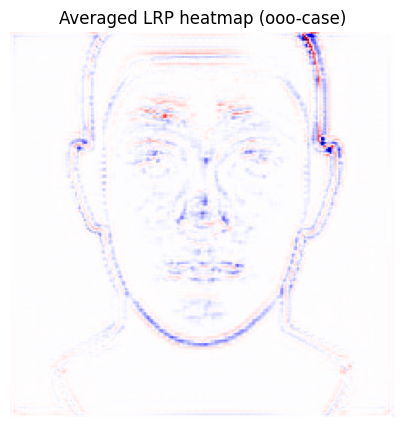

In [ ]:
heatmap_folder = local_paths.DIR_AVERAGE_HEATMAPS_HUM
heatmap_path = os.path.join(heatmap_folder, "head_001_average_odd_one_out_VGGFaceHumanJudgment.png")
heatmap = cv2.imread(heatmap_path)
plt.figure(figsize=(5,5))
plt.imshow(heatmap)
plt.axis("off")
plt.title("Averaged LRP heatmap (ooo-case)")
plt.show()

In [10]:
# convert to grayscale for summing up relevance
gray_lrp = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)
gray_lrp = gray_lrp.astype(np.float32)

In [11]:
# Compute both sum and pixel count for each region
region_stats_lrp = {
    name: get_region_stats(gray_lrp, points, idxs)
    for name, idxs in region_map.items()
}

df_lrp = pd.DataFrame(
    [(name, s, px) for name, (s, px) in region_stats_lrp.items()],
    columns=["region", "sum", "pixels"]
)
print(df_lrp)

                region      sum  pixels
0                mouth   198537     822
1             nose_tip   200064     826
2          nose_bridge   140443     568
3             left_eye   155029     627
4   space between eyes    27227     112
5             forehead   448327    1831
6                 chin   387757    1545
7              contour  3417798   13787
8           left_cheek   373169    1480
9         left_eyebrow   110139     447
10           right_eye   158231     640
11         right_cheek   393023    1563
12       right_eyebrow   128185     520


In [12]:
# filter out contour for normalization
region_stats_filtered = {k: v for k, v in region_stats_lrp.items() if k != "contour"}

In [13]:
# --- compute total for global normalization ---
total_sum = sum(s for s, px in region_stats_filtered.values())

# --- build rows for the dataframe ---
rows = []
for region, (sum_val, pixel_count) in region_stats_filtered.items():
    mean_per_pixel = sum_val / pixel_count if pixel_count > 0 else 0
    global_norm = sum_val / total_sum if total_sum > 0 else 0

    rows.append({
        "region": region,
        "sum": sum_val,
        "pixels": pixel_count,
        "mean_per_pixel": mean_per_pixel, 
        "global_norm": global_norm          
    })

df_all = pd.DataFrame(rows)
df_all_sorted = df_all.sort_values("global_norm", ascending=True)

print(df_all_sorted)

                region     sum  pixels  mean_per_pixel  global_norm
4   space between eyes   27227     112      243.098214     0.010009
8         left_eyebrow  110139     447      246.395973     0.040490
11       right_eyebrow  128185     520      246.509615     0.047125
2          nose_bridge  140443     568      247.258803     0.051631
3             left_eye  155029     627      247.255183     0.056993
9            right_eye  158231     640      247.235938     0.058170
0                mouth  198537     822      241.529197     0.072988
1             nose_tip  200064     826      242.208232     0.073549
7           left_cheek  373169    1480      252.141216     0.137188
6                 chin  387757    1545      250.975405     0.142551
10         right_cheek  393023    1563      251.454255     0.144487
5             forehead  448327    1831      244.853632     0.164818


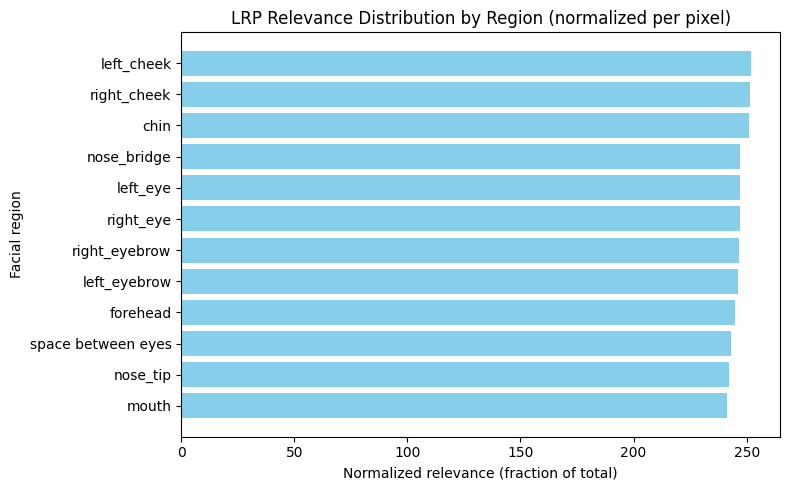

In [14]:
import matplotlib.pyplot as plt

df_all_sorted = df_all.sort_values("mean_per_pixel", ascending=True)

plt.figure(figsize=(8,5))

plt.barh(df_all_sorted["region"], df_all_sorted["mean_per_pixel"], color="skyblue")
plt.xlabel("Normalized relevance (fraction of total)")
plt.ylabel("Facial region")
plt.title("LRP Relevance Distribution by Region (normalized per pixel)")
plt.tight_layout()
plt.show()


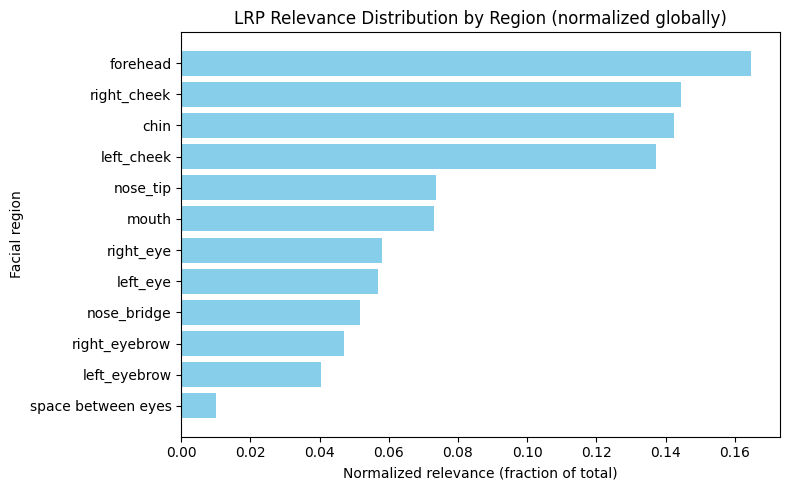

In [15]:
import matplotlib.pyplot as plt

df_all_sorted = df_all.sort_values("global_norm", ascending=True)

plt.figure(figsize=(8,5))

plt.barh(df_all_sorted["region"], df_all_sorted["global_norm"], color="skyblue")
plt.xlabel("Normalized relevance (fraction of total)")
plt.ylabel("Facial region")
plt.title("LRP Relevance Distribution by Region (normalized globally)")
plt.tight_layout()
plt.show()


In [16]:
# looks better but can be misleading as regions have very different numbers of pixels
df_all_sorted = df_all.sort_values("pixels", ascending=True)
print(df_all_sorted)

                region     sum  pixels  mean_per_pixel  global_norm
4   space between eyes   27227     112      243.098214     0.010009
8         left_eyebrow  110139     447      246.395973     0.040490
11       right_eyebrow  128185     520      246.509615     0.047125
2          nose_bridge  140443     568      247.258803     0.051631
3             left_eye  155029     627      247.255183     0.056993
9            right_eye  158231     640      247.235938     0.058170
0                mouth  198537     822      241.529197     0.072988
1             nose_tip  200064     826      242.208232     0.073549
7           left_cheek  373169    1480      252.141216     0.137188
6                 chin  387757    1545      250.975405     0.142551
10         right_cheek  393023    1563      251.454255     0.144487
5             forehead  448327    1831      244.853632     0.164818


## Analysize results from the mediapipe_relevance_per_region.py (uses pixel-level normalization)

      mouth  nose_tip  nose_bridge  left_eye  space between eyes  forehead  \
0  0.000315  0.000310     0.000248  0.000194            0.000405 -0.000040   
1 -0.001399 -0.002213    -0.000527 -0.001067           -0.002133 -0.000003   
2 -0.000035  0.000232     0.000118  0.000249            0.001035  0.000008   
3  0.000170  0.000165    -0.000014 -0.000009           -0.000092 -0.000046   
4  0.000503  0.000636     0.000484  0.000481            0.000413 -0.000014   

       chin  left_cheek  left_eyebrow  right_eye  right_cheek  right_eyebrow  \
0  0.000056    0.000066      0.000046   0.000203     0.000084       0.000183   
1 -0.000394   -0.000444     -0.000756  -0.000911    -0.000559      -0.000660   
2 -0.000009    0.000045      0.000177   0.000156     0.000045       0.000182   
3  0.000303    0.000027     -0.000012  -0.000054     0.000022      -0.000060   
4  0.000207    0.000144      0.000367   0.001012     0.000160       0.000758   

             image_name  
0  head-001_frontal.png 

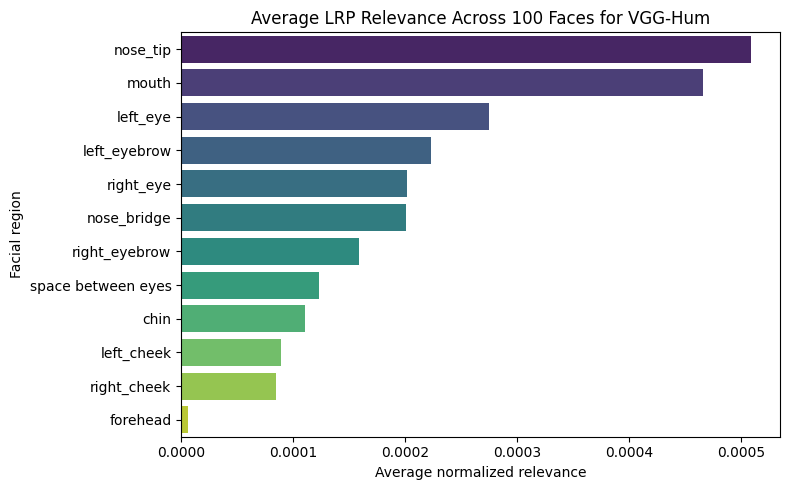

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# Path to your saved dataset
csv_path_hj = os.path.join(results_folder,"relevance_per_region_dataset_hj.csv")

df_hj = pd.read_csv(csv_path_hj)
print(df_hj.head())

region_cols_hj = [c for c in df_hj.columns if c != "image_name"]
region_data_hj = df_hj[region_cols_hj]

mean_scores_hj = region_data_hj.mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sn.barplot(x=mean_scores_hj.values, y=mean_scores_hj.index, palette="viridis")
plt.xlabel("Average normalized relevance")
plt.ylabel("Facial region")
plt.title("Average LRP Relevance Across 100 Faces for VGG-Hum")
plt.tight_layout()
plt.show()


      mouth  nose_tip  nose_bridge  left_eye  space between eyes  forehead  \
0  0.000762  0.001104     0.000845  0.000937            0.002263  0.000462   
1  0.000509  0.001125     0.000397  0.000816            0.001728  0.000105   
2  0.000313  0.000642     0.000357  0.000537            0.001846  0.000180   
3  0.000109  0.000242     0.000252  0.000236            0.000292  0.000002   
4  0.000387  0.000527     0.000347  0.000574            0.000317 -0.000009   

       chin  left_cheek  left_eyebrow  right_eye  right_cheek  right_eyebrow  \
0  0.000125    0.000280      0.000790   0.001041     0.000279       0.001029   
1  0.000109    0.000222      0.000734   0.000775     0.000233       0.000743   
2  0.000052    0.000103      0.000719   0.000504     0.000121       0.000567   
3  0.000109    0.000048      0.000218   0.000228     0.000051       0.000212   
4  0.000136    0.000138      0.000531   0.000415     0.000085       0.000324   

             image_name  
0  head-001_frontal.png 

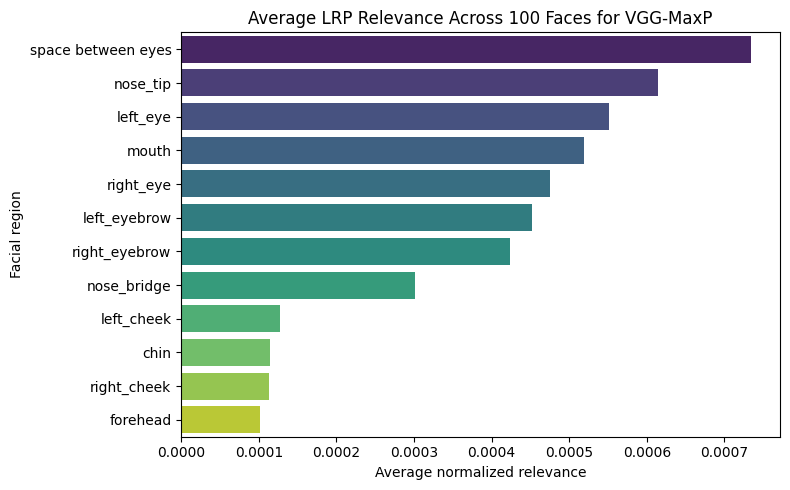

In [ ]:
# Path to your saved dataset
csv_path_maxp = os.path.join(results_folder, "relevance_per_region_dataset_maxpSim.csv")

df_maxp = pd.read_csv(csv_path_maxp)
print(df_maxp.head())

region_cols_maxp = [c for c in df_maxp.columns if c != "image_name"]
region_data_maxp = df_maxp[region_cols_maxp]

mean_scores_maxp = region_data_maxp.mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sn.barplot(x=mean_scores_maxp.values, y=mean_scores_maxp.index, palette="viridis")
plt.xlabel("Average normalized relevance")
plt.ylabel("Facial region")
plt.title("Average LRP Relevance Across 100 Faces for VGG-MaxP")
plt.tight_layout()
plt.show()

# Statistics

In [ ]:
import pandas as pd
from scipy.stats import shapiro

region_cols = [c for c in df_hj.columns if c != "image_name"]

print("Normality test results (Shapiro–Wilk):")
for region in region_cols:
    stat_hj, p_hj = shapiro(df_hj[region])
    stat_mp, p_mp = shapiro(df_maxp[region])
    print(f"{region:20s} | HJ p={p_hj:.4f} | MaxP p={p_mp:.4f}")

Normality test results (Shapiro–Wilk):
mouth                | HJ p=0.0000 | MaxP p=0.0000
nose_tip             | HJ p=0.0000 | MaxP p=0.0000
nose_bridge          | HJ p=0.0000 | MaxP p=0.0000
left_eye             | HJ p=0.0000 | MaxP p=0.0000
space between eyes   | HJ p=0.0000 | MaxP p=0.0000
forehead             | HJ p=0.0000 | MaxP p=0.0000
chin                 | HJ p=0.0000 | MaxP p=0.0000
left_cheek           | HJ p=0.0014 | MaxP p=0.0000
left_eyebrow         | HJ p=0.0000 | MaxP p=0.0000
right_eye            | HJ p=0.0000 | MaxP p=0.0000
right_cheek          | HJ p=0.0000 | MaxP p=0.0000
right_eyebrow        | HJ p=0.0000 | MaxP p=0.0000


## 4. Comparing Models: Human Judgment vs. MaxP Similarity

We prepare the extracted regional relevance data for statistical comparison by melting it into a long format. 
This allows us to compare the distribution of focus between the 'Human Judgment' baseline and the 'MaxP Sim' model predictions.

In [ ]:
# Melt both datasets into long format
hj_long = df_hj.melt(id_vars="image_name", value_vars=region_cols,
                  var_name="region", value_name="relevance")
hj_long["model"] = "Human Judgment"

maxp_long = df_maxp.melt(id_vars="image_name", value_vars=region_cols,
                      var_name="region", value_name="relevance")
maxp_long["model"] = "MaxP Sim"

# Combine both
df_long = pd.concat([hj_long, maxp_long], ignore_index=True)

In [25]:
df_long

,image_name,region,relevance,model
0,head-001_frontal.png,mouth,0.000315,Human Judgment
1,head-002_frontal.png,mouth,-0.001399,Human Judgment
2,head-003_frontal.png,mouth,-0.000035,Human Judgment
3,head-004_frontal.png,mouth,0.000170,Human Judgment
4,head-005_frontal.png,mouth,0.000503,Human Judgment
...,...,...,...,...
2395,head-096_frontal.png,right_eyebrow,0.000896,MaxP Sim
2396,head-097_frontal.png,right_eyebrow,0.000411,MaxP Sim
2397,head-098_frontal.png,right_eyebrow,0.001281,MaxP Sim
2398,head-099_frontal.png,right_eyebrow,0.000715,MaxP Sim


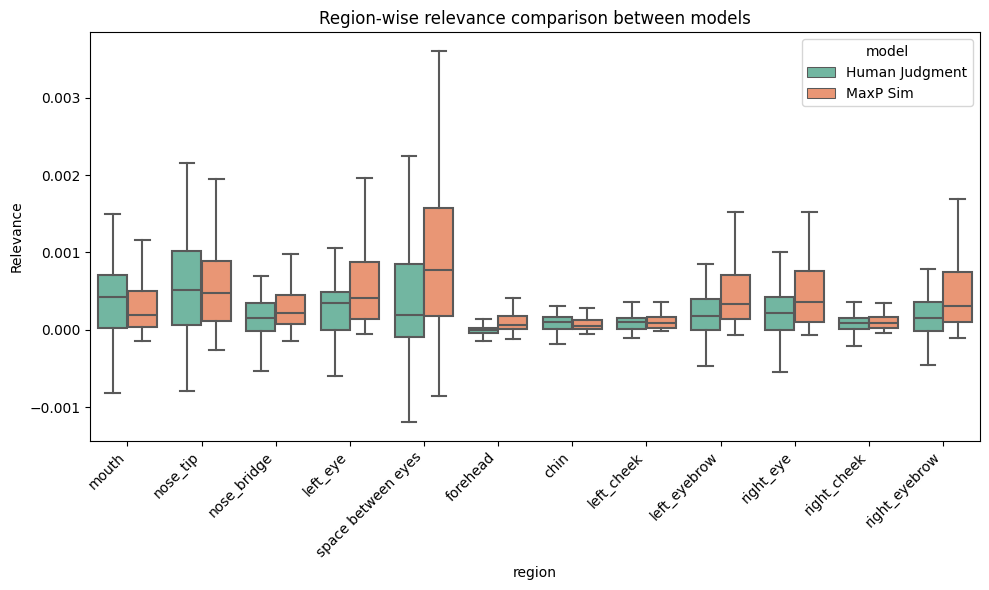

In [26]:
import matplotlib.pyplot as plt
import seaborn as sn

plt.figure(figsize=(10,6))
sn.boxplot(x="region", y="relevance", hue="model", data=df_long, palette="Set2", showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Relevance")
plt.title("Region-wise relevance comparison between models")
plt.tight_layout()
plt.show()

### 4.1 Statistical Significance of Differences

We use the Wilcoxon signed-rank test to determine if the differences in relevance assigned to each region by the two models are statistically significant.

In [27]:
from scipy.stats import wilcoxon

pvals = []
for region in df_long["region"].unique():
    hj_vals = df_long.loc[(df_long["region"] == region) & (df_long["model"] == "Human Judgment"), "relevance"]
    maxp_vals = df_long.loc[(df_long["region"] == region) & (df_long["model"] == "MaxP Sim"), "relevance"]
    
    stat, p = wilcoxon(hj_vals, maxp_vals)
    pvals.append({"region": region, "p_value": p})

sig_df = pd.DataFrame(pvals)
sig_df["significant"] = sig_df["p_value"] < 0.05
sig_df = sig_df.sort_values("p_value", ascending=True)
print(sig_df)

                region       p_value  significant
5             forehead  4.114194e-09         True
4   space between eyes  2.310279e-05         True
11       right_eyebrow  4.137420e-04         True
8         left_eyebrow  5.152354e-04         True
9            right_eye  5.353945e-04         True
3             left_eye  2.452314e-03         True
2          nose_bridge  1.686509e-02         True
7           left_cheek  2.355346e-01        False
6                 chin  2.396320e-01        False
0                mouth  2.667496e-01        False
10         right_cheek  3.170432e-01        False
1             nose_tip  7.595963e-01        False


In [28]:
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return "ns"

sig_df["stars"] = sig_df["p_value"].apply(p_to_stars)

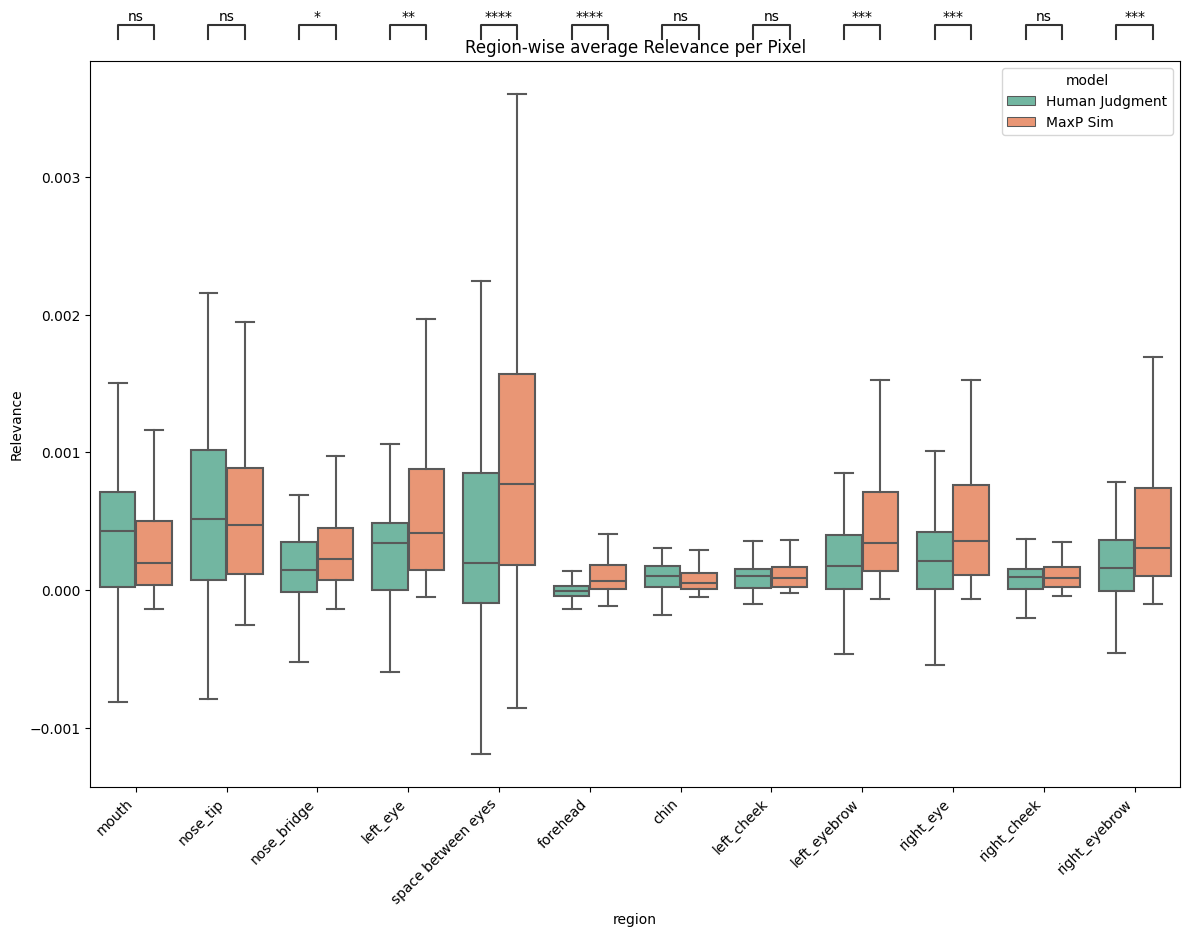

In [ ]:
from statannotations.Annotator import Annotator

# Define your plot
plt.figure(figsize=(12,8))
ax = sn.boxplot(x="region", y="relevance", hue="model", data=df_long, palette="Set2", showfliers=False)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Relevance")
plt.title("Region-wise average Relevance per Pixel")

# Define pairs to test (Human Judgment vs MaxP Sim for each region)
pairs = [((region, "Human Judgment"), (region, "MaxP Sim")) for region in df_long["region"].unique()]

# Initialize annotator
annot = Annotator(ax, pairs, data=df_long, x="region", y="relevance", hue="model")

# Configure with your test and annotation style
annot.configure(test="Wilcoxon", text_format="star", loc="outside", verbose=False)
annot.apply_and_annotate()

plt.tight_layout()
plt.subplots_adjust(top=1.1) 
#plt.savefig("comparison_relevance_per_region_stats.png", dpi=300)
plt.show()